In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import datetime as dt
import math as mt

In [2]:
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

In [3]:
PATH = ''

### Load Data and Inspect

In [4]:
X_train = pd.read_csv(PATH+"X_train.csv")
X_train = X_train.drop(X_train.columns[-1],axis=1)
X_train.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
y_train = pd.read_csv(PATH+"y_train.csv")
y_train.head(5)

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


In [6]:
X_test = pd.read_csv(PATH+"X_test.csv")
X_test = X_test.drop(X_test.columns[-1],axis=1)
X_test.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2014-01-01T00:00:00.0,312.2222,30.0,8.4,86.0,8.4,5.6,17.0,1016.6
1,2014-01-01T00:01:00.0,318.8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01T00:02:00.0,314.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01T00:03:00.0,311.4444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-01T00:04:00.0,310.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X_train = X_train.sort_values(by="time_step")
y_train = y_train.sort_values(by="time_step")

### Missing Value Imputation

In [8]:
sample1 = X_train.interpolate(method='linear')
sample1 = sample1.interpolate(method='linear', limit_direction='both')
sample1['consumption'] = X_train['consumption']
X_train_imputed = sample1.copy()
X_train_imputed.isna().sum()

time_step          0
consumption    10231
visibility         0
temperature        0
humidity           0
humidex            0
windchill          0
wind               0
pressure           0
dtype: int64

In [9]:
X_train_imputed_3min = X_train_imputed.interpolate(method='nearest', limit_direction='forward', limit=3)

In [10]:
sample2 = X_test.interpolate(method='linear')
sample2 = sample2.interpolate(method='linear', limit_direction='both')
sample2['consumption'] = X_test['consumption']
X_test_imputed = sample2.copy()

In [11]:
y_train_imputed_3min = y_train.interpolate(method='nearest', limit_direction='forward', limit=3)

In [12]:
X_train_A = X_train_imputed_3min.copy()
X_test_A = X_test_imputed.copy()
y_train_A = y_train_imputed_3min.copy()

### Data Integration

In [13]:
train = pd.merge(X_train_A, y_train_A,
                 how="left",
                 left_on=['time_step'],
                 right_on=['time_step'],
                 sort=False
                )

### Visualization

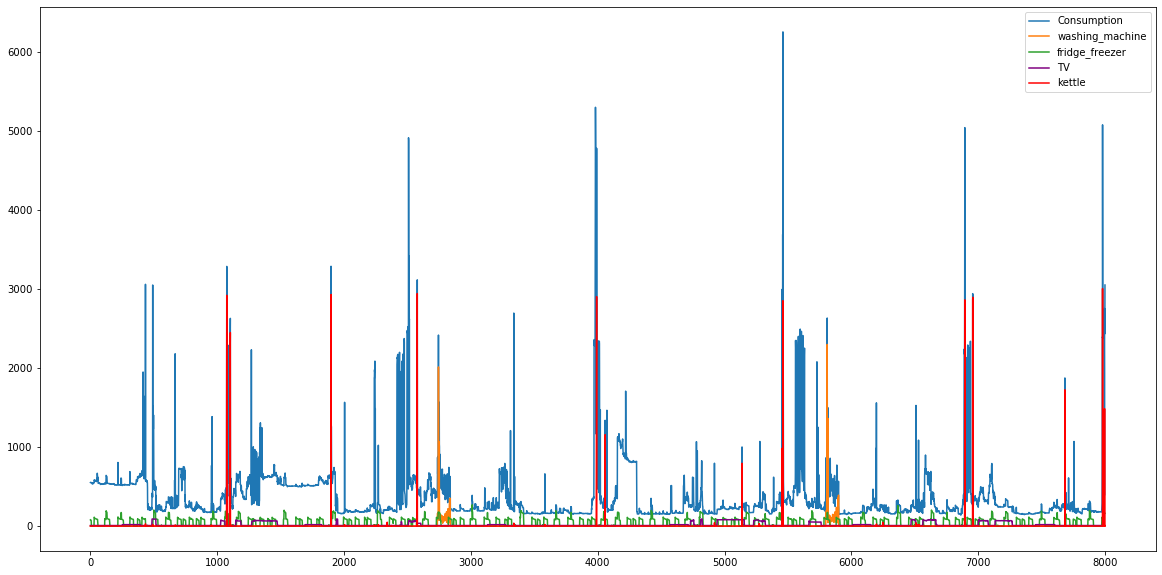

In [14]:
fig = plt.figure(figsize=(20,10))

size = 8000

plot_sample = train.iloc[:size,:]
plt.plot(np.arange(0,size,1), plot_sample['consumption'], label='Consumption')
plt.plot(np.arange(0,size,1), plot_sample['washing_machine'], label='washing_machine')
plt.plot(np.arange(0,size,1), plot_sample['fridge_freezer'], label='fridge_freezer')
plt.plot(np.arange(0,size,1), plot_sample['TV'], label='TV', color="purple")
plt.plot(np.arange(0,size,1), plot_sample['kettle'], label='kettle', color="red")

plt.legend()

plt.show()

In [15]:
train_notnull = train[train['consumption'].notna()]

### Linear Model

In [16]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [17]:
X_vars = ['consumption', 'visibility', 'temperature', 'humidity','humidex',
                   'windchill', 'wind', 'pressure']
y_vars = ['washing_machine','fridge_freezer','TV','kettle']

In [18]:
X = train_notnull[X_vars]
y = train_notnull[y_vars]

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [20]:
len(y_scaled[:,0])

409610

1 - washing_machine; 2 - fridge_freezer; 3 - TV; 4 - kettle;

In [21]:
y_test = X_test_A[['time_step']]

In [22]:
X_test_B = X_test_A.fillna(0)

In [23]:
reg1 = LinearRegression().fit(X_scaled, y_scaled[:,0])
y_test['washing_machine'] = reg1.predict(X_test_B[X_vars])

reg2 = LinearRegression().fit(X_scaled, y_scaled[:,1])
y_test['fridge_freezer'] = reg2.predict(X_test_B[X_vars])

reg3 = LinearRegression().fit(X_scaled, y_scaled[:,2])
y_test['TV'] = reg3.predict(X_test_B[X_vars])

reg4 = LinearRegression().fit(X_scaled, y_scaled[:,3])
y_test['kettle'] = reg4.predict(X_test_B[X_vars])

In [24]:
y_test['washing_machine'].loc[X_test_A['consumption'].isnull()] = np.nan
y_test['fridge_freezer'].loc[X_test_A['consumption'].isnull()] = np.nan
y_test['TV'].loc[X_test_A['consumption'].isnull()] = np.nan
y_test['kettle'].loc[X_test_A['consumption'].isnull()] = np.nan

### Feature Engineering

In [25]:
train_notnull['date'] = train_notnull['time_step'].str[:10]
train_notnull['hour'] = train_notnull['time_step'].str[11:13].astype('int')

train_notnull['date'] = pd.to_datetime(train_notnull['date'], infer_datetime_format=True)

train_notnull['dayofweek'] = train_notnull['date'].dt.dayofweek

In [26]:
isweekend = []
for day in list(train_notnull['dayofweek']):
    if day in [5,6]:
        isweekend.append(1)
    else:
        isweekend.append(0)
train_notnull['isweekend'] = isweekend

In [27]:
train_notnull = train_notnull.drop(['date'], axis=1)

In [28]:
train_notnull.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'washing_machine',
       'fridge_freezer', 'TV', 'kettle', 'hour', 'dayofweek', 'isweekend'],
      dtype='object')

In [29]:
X_vars2 = X_vars + ['hour','isweekend']

### ELM / Hierarchical-ELMs (H-ELMs)

In [33]:
! pip install sklearn --upgrade
import sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=7ff64bcff4b45fbc795fc83905d2fde124c608444cda24d3fadfe514f7a2dbd1
  Stored in directory: /Users/FerdinandYu/Library/Caches/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [35]:
from elm2 import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer